In [3]:
from mne.minimum_norm import apply_inverse, make_inverse_operator
import mne

# Source Localization - Production and Comprehension Priming Study
Everything in this notebook is automatic except for the **covariance rank**. The MNE function to automatically calculate the rank does not work well. Instead of using that, it is necessary to manually set the rank for each subject/task. Test values until you find one that creates a vertical line right before the noise drops off dramatically. You should see a small slope directly to the left of the rank line. If you do not manually set the rank, your inverse operator will only explain a very small percent of the variance in the original data.

In [66]:
sub = 'R3329' #Only variable you need to change other than rank

In [ ]:
def localization_with_rank(sub, comp_rank, prod_rank):

In [67]:
# Setting parameters to be used by both production and comprehension
subjects_dir = '/Applications/freesurfer/8.0.0/subjects' # freesurfer MRI directory
directory = '/Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/MEG_data/Testing/' + sub + '/'
trans_dir = '/Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/MEG_data/' + sub + '/'

conductivity = (0.3,) # single layer conductivity
baseline_start = -300 #in milliseconds
baseline_end = 0
baseline = (None,0)
snr = 3.0
method = "dSPM"

# LOAD COMPREHENSION AND PRODUCTION DATA
# load epochs
epoch_fname_comp = directory + sub + '_comp-epo.fif'
epochs_comp = mne.read_epochs(epoch_fname_comp, proj=False)
epoch_fname_prod = directory + sub + '_prod-epo.fif'
epochs_prod = mne.read_epochs(epoch_fname_prod, proj=False)


# Reject bad epochs that have a max peak to peak signal amplitude that exceeds 3 picoteslas
reject_criteria = dict(mag=3000e-15)
epochs_prod.drop_bad(reject=reject_criteria)
epochs_comp.drop_bad(reject=reject_criteria)


# Equalize epoch counts for each condition
ident_prod = epochs_prod['production identical'].pick('mag')
unrel_prod = epochs_prod['production unrelated'].pick('mag')
ident_comp = epochs_comp['comprehension identical'].pick('mag')
unrel_comp = epochs_comp['comprehension unrelated'].pick('mag')
mne.epochs.equalize_epoch_counts([ident_prod, ident_comp, unrel_prod, unrel_comp], method="random")

# Create evoked objects low pass filtered at 40 Hz
ident_prod = ident_prod.average().filter(l_freq=None, h_freq=40)
unrel_prod = unrel_prod.average().filter(l_freq=None, h_freq=40)
ident_comp = ident_comp.average().filter(l_freq=None, h_freq=40)
unrel_comp = unrel_comp.average().filter(l_freq=None, h_freq=40)

# Make anatomical model -- does not use head position information
subject = sub
model = mne.make_bem_model(subject=subject, ico=4, conductivity=conductivity, subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)
src = mne.setup_source_space(subject, spacing="oct6", add_dist="patch", subjects_dir=subjects_dir)

Reading /Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/MEG_data/Testing/R3329/R3329_comp-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
150 matching events found
No baseline correction applied
Reading /Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/MEG_data/Testing/R3329/R3329_prod-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
118 matching events found
No baseline correction applied
    Rejecting  epoch based on MAG : ['MEG 100']
    Rejecting  epoch based on MAG : ['MEG 064', 'MEG 066', 'MEG 067', 'MEG 100']
2 bad epochs dropped
0 bad epochs dropped
Dropped 20 epochs: 0, 2, 4, 6, 7, 12, 13, 17, 21, 23, 25, 29, 31, 35, 38, 39, 43, 44, 45, 46
Dropped 21 epochs: 3, 8, 9, 10, 14, 18, 19, 20, 21, 22, 24, 26, 28, 29, 30, 31, 32, 34, 39, 47, 48

## Comprehension

In [68]:
epochs_comp = epochs_comp.interpolate_bads()

Setting channel interpolation method to {'meg': 'MNE'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 92.4 mm
    Computing dot products for 153 MEG channels...
    Computing cross products for 153 → 4 MEG channels...
    Preparing the mapping matrix...
    Truncating at 64/153 components to omit less than 0.0001 (9.3e-05)


    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 157 -> 147
Estimating covariance using SHRUNK
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 45150
log-likelihood on unseen data (descending order):
   shrunk: -834.409
   empirical: -834.409
selecting best estimator: shrunk
[done]
Computing rank from covariance with rank=None
    Using tolerance 1.2e-14 (2.2e-16 eps * 157 dim * 0.35  max singular value)
    Estimated rank (mag): 147
    MAG: rank 147 computed from 157 data channels with 0 projectors


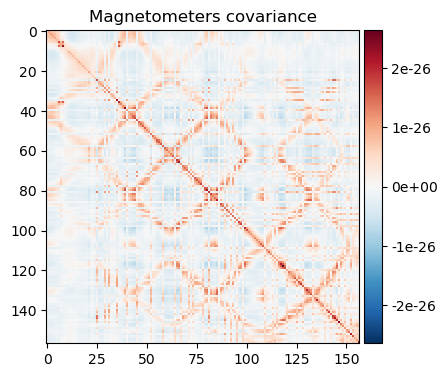

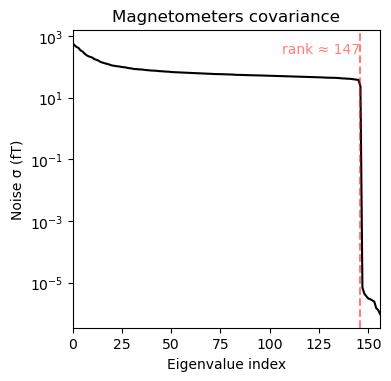

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [70]:
# Compute the noise covariance using the baseline interval
# mne.compute_rank(epochs_comp, tmin=baseline_start, tmax=baseline_end)
rank = {'mag': 147}
noise_cov_comp = mne.compute_covariance(epochs_comp, tmin=baseline_start, tmax=baseline_end,
                                        method=["shrunk", "empirical"],rank=rank, verbose=True)
mne.viz.plot_cov(noise_cov_comp, epochs_comp.info)

In [71]:
raw_fname_comp = directory + sub + '_comp_preproc-raw.fif'
trans = trans_dir + sub + '-trans.fif'

# Compute forward solution
fwd_comp = mne.make_forward_solution(
    raw_fname_comp,
    trans=trans,
    src=src,
    bem=bem,
    meg=True,
    eeg=False,
    mindist=5.0,
    ignore_ref=True
)
lambda2 = 1.0 / snr ** 2

# Calculate inverse operators
inverse_ident_comp = make_inverse_operator(ident_comp.info, fwd_comp, noise_cov_comp, loose=0.2, depth=0.8)
inverse_unrel_comp = make_inverse_operator(unrel_comp.info, fwd_comp, noise_cov_comp, loose=0.2, depth=0.8)

# Calculate STCs using evoked data, inverse operators from above
stc_ident_comp = apply_inverse(ident_comp, inverse_ident_comp, lambda2, method=method, pick_ori="normal")
stc_unrel_comp = apply_inverse(unrel_comp, inverse_unrel_comp, lambda2, method=method, pick_ori="normal")

fname_ident_comp = directory + sub + '_ident_comp'
stc_ident_comp.save(fname_ident_comp, ftype='stc', overwrite=True)
fname_unrel_comp = directory + sub + '_unrel_comp'
stc_unrel_comp.save(fname_unrel_comp, ftype='stc', overwrite=True)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'R3329', ~31.3 MiB>
MRI -> head transform : /Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/MEG_data/R3329/R3329-trans.fif
Measurement data      : R3329_comp_preproc-raw.fif
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999929 0.011250 -0.003822      -2.79 mm
    -0.011013 0.998300 0.057231      26.85 mm
    0.004460 -0.057185 0.998354      39.53 mm
    0.000000 0.000000 0.000000       1.00

Read 157 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
    0.995548 0.028014 -0.089997      -1.80 mm
    0.011877 0.909920 0.414613       4.80 mm
    0.09

## Production

In [72]:
epochs_prod = epochs_prod.interpolate_bads()

Setting channel interpolation method to {'meg': 'MNE'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 92.4 mm
    Computing dot products for 153 MEG channels...
    Computing cross products for 153 → 4 MEG channels...
    Preparing the mapping matrix...
    Truncating at 63/153 components to omit less than 0.0001 (9.4e-05)


    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 157 -> 147
Estimating covariance using SHRUNK
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 34916
log-likelihood on unseen data (descending order):
   shrunk: -833.997
   empirical: -833.998
selecting best estimator: shrunk
[done]
Computing rank from covariance with rank=None
    Using tolerance 1.1e-14 (2.2e-16 eps * 157 dim * 0.32  max singular value)
    Estimated rank (mag): 147
    MAG: rank 147 computed from 157 data channels with 0 projectors


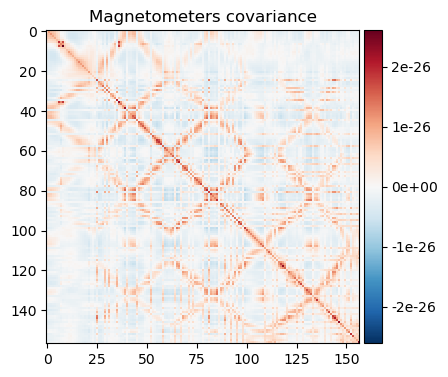

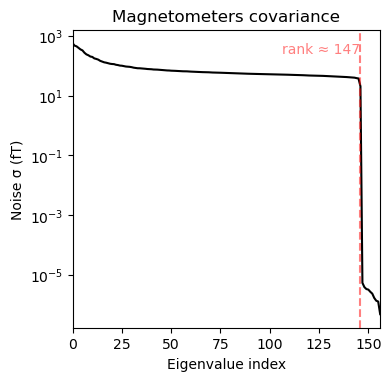

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [74]:
# Compute the noise covariance using the baseline interval
# rank = None
rank = {'mag': 147}
noise_cov_prod = mne.compute_covariance(epochs_prod, tmin=baseline_start, tmax=baseline_end, method=["shrunk", "empirical"], rank=rank, verbose=True)
mne.viz.plot_cov(noise_cov_prod, epochs_prod.info)

In [75]:
raw_fname_prod = directory + sub + '_prod_preproc-raw.fif'
trans = trans_dir + sub + '-trans.fif'

# Compute forward solution
fwd_prod = mne.make_forward_solution(
    raw_fname_prod,
    trans=trans,
    src=src,
    bem=bem,
    meg=True,
    eeg=False,
    mindist=5.0,
    ignore_ref=True
)
lambda2 = 1.0 / snr ** 2

# Calculate inverse operators
inverse_ident_prod = make_inverse_operator(ident_prod.info, fwd_prod, noise_cov_prod, loose=0.2, depth=0.8)
inverse_unrel_prod = make_inverse_operator(unrel_prod.info, fwd_prod, noise_cov_prod, loose=0.2, depth=0.8)

# Calculate STCs using evoked data, inverse operators from above
stc_ident_prod = apply_inverse(ident_prod, inverse_ident_prod, lambda2, method=method, pick_ori="normal")
stc_unrel_prod = apply_inverse(unrel_prod, inverse_unrel_prod, lambda2, method=method, pick_ori="normal")

fname_ident_comp = directory + sub + '_ident_prod'
stc_ident_prod.save(fname_ident_comp, ftype='stc', overwrite=True)
fname_unrel_comp = directory + sub + '_unrel_prod'
stc_unrel_prod.save(fname_unrel_comp, ftype='stc', overwrite=True)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'R3329', ~31.3 MiB>
MRI -> head transform : /Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/MEG_data/R3329/R3329-trans.fif
Measurement data      : R3329_prod_preproc-raw.fif
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999929 0.011250 -0.003822      -2.79 mm
    -0.011013 0.998300 0.057231      26.85 mm
    0.004460 -0.057185 0.998354      39.53 mm
    0.000000 0.000000 0.000000       1.00

Read 157 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
    0.995161 0.027282 -0.094396      -1.78 mm
    0.012979 0.915770 0.401494       5.13 mm
    0.09

## Plot generated STCs

In [58]:
stcs = {
        'Comprehension identical':stc_ident_comp,
        'Comprehension unrelated': stc_unrel_comp,
        'Production identical': stc_ident_prod,
        'Production unrelated':stc_unrel_prod,
}

brains = []

cmaps = ['hot', 'cool', 'spring', 'winter']
for (title, stc), cmap in zip(stcs.items(), cmaps):
    brain = stc.plot(
        subjects_dir=subjects_dir,
        hemi='lh',
        colormap=cmap,
        clim=dict(kind="value", lims=[3, 6, 9]),
        smoothing_steps=7,
        title=title
    )
    brain.add_text(0.1, 0.9, title, "title", font_size=14)
    brains.append(brain)  # Save each brain object


# Source Localization -- Auditory

In [1]:
sub = 'R3326'

In [4]:
# Setting parameters to be used by both production and comprehension
subjects_dir = '/Applications/freesurfer/8.0.0/subjects' # freesurfer MRI directory
directory = '/Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/MEG_data/' + sub + '/'

conductivity = (0.3,) # single layer conductivity
baseline_start = -300 #in milliseconds
baseline_end = 0
baseline = (None,0)
snr = 3.0
method = "dSPM"

# LOAD COMPREHENSION AND PRODUCTION DATA
# load epochs
epoch_fname_comp = directory + sub + '_comp_aud-epo.fif'
epochs_aud_comp = mne.read_epochs(epoch_fname_comp, proj=False)
epoch_fname_prod = directory + sub + '_prod_aud-epo.fif'
epochs_aud_prod = mne.read_epochs(epoch_fname_prod, proj=False)


# Reject bad epochs that have a max peak to peak signal amplitude that exceeds 3 picoteslas
reject_criteria = dict(mag=3000e-15)
epochs_aud_prod.drop_bad(reject=reject_criteria)
epochs_aud_comp.drop_bad(reject=reject_criteria)


# Equalize epoch counts for each condition
aud_prod = epochs_aud_prod['audio onset'].pick('mag')
aud_comp = epochs_aud_comp['audio onset'].pick('mag')
mne.epochs.equalize_epoch_counts([aud_prod, aud_comp], method="random")

# Create evoked objects low pass filtered at 40 Hz
aud_prod = aud_prod.average().filter(l_freq=None, h_freq=40)
aud_comp = aud_comp.average().filter(l_freq=None, h_freq=40)

# Make anatomical model -- does not use head position information
subject = sub
model = mne.make_bem_model(subject=subject, ico=4, conductivity=conductivity, subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)
src = mne.setup_source_space(subject, spacing="oct6", add_dist="patch", subjects_dir=subjects_dir)

FileNotFoundError: File does not exist: "/Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/MEG_data/R3326/R3326_comp_aud-epo.fif"

## Comprehension


    Created an SSP operator (subspace dimension = 2)
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 157 -> 147
Estimating covariance using SHRUNK
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 89698
log-likelihood on unseen data (descending order):
   shrunk: -811.341
   empirical: -829.015
selecting best estimator: shrunk
[done]
Computing rank from covariance with rank=None
    Using tolerance 1e-14 (2.2e-16 eps * 157 dim * 0.29  max singular value)
    Estimated rank (mag): 147
    MAG: rank 147 computed from 157 data channels with 0 projectors


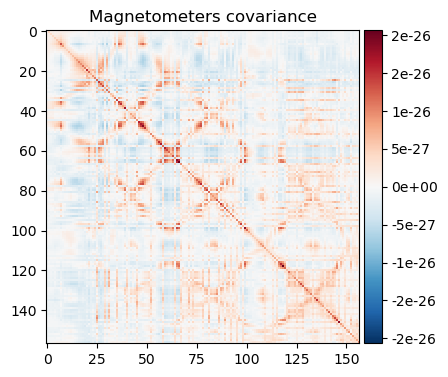

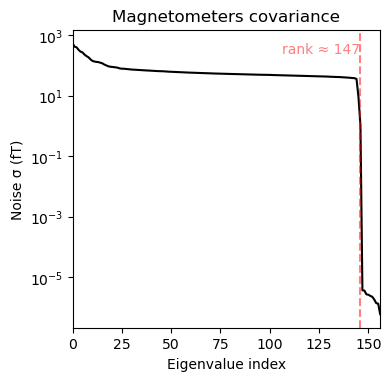

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [87]:
rank = {'mag': 147}
noise_cov_comp = mne.compute_covariance(epochs_aud_comp, tmin=baseline_start, tmax=baseline_end,
                                        method=["shrunk", "empirical"], rank=rank, verbose=True)
mne.viz.plot_cov(noise_cov_comp, aud_comp.info)

In [88]:
raw_fname_comp = directory + sub + '_comp_preproc-raw.fif'
trans = directory + sub + '-trans.fif'

# Compute forward solution
fwd_comp = mne.make_forward_solution(
    raw_fname_comp,
    trans=trans,
    src=src,
    bem=bem,
    meg=True,
    eeg=False,
    mindist=5.0,
    ignore_ref=True
)
lambda2 = 1.0 / snr ** 2

# Calculate inverse operators
inverse_aud_comp = make_inverse_operator(aud_comp.info, fwd_comp, noise_cov_comp, loose=0.2, depth=0.8)

# Calculate STCs using evoked data, inverse operators from above
stc_aud_comp = apply_inverse(aud_comp, inverse_aud_comp, lambda2, method=method, pick_ori="normal")

fname_aud_comp = directory + sub + '_aud_comp'
stc_aud_comp.save(fname_aud_comp, ftype='stc', overwrite=True)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'R3261', ~31.3 MiB>
MRI -> head transform : /Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/MEG_data/R3261/R3261-trans.fif
Measurement data      : R3261_comp_preproc-raw.fif
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999623 0.022839 0.015242      -2.83 mm
    -0.023797 0.997538 0.065970      25.55 mm
    -0.013698 -0.066308 0.997705      39.08 mm
    0.000000 0.000000 0.000000       1.00

Read 157 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
    0.998741 0.006496 0.049749      -3.57 mm
    -0.025581 0.918942 0.393562       3.99 mm
    -0.0

## Production

    Created an SSP operator (subspace dimension = 2)
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 157 -> 146
Estimating covariance using SHRUNK
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 86688
log-likelihood on unseen data (descending order):
   shrunk: -813.404
   empirical: -813.404
selecting best estimator: shrunk
[done]
Computing rank from covariance with rank=None
    Using tolerance 1e-14 (2.2e-16 eps * 157 dim * 0.29  max singular value)
    Estimated rank (mag): 146
    MAG: rank 146 computed from 157 data channels with 0 projectors


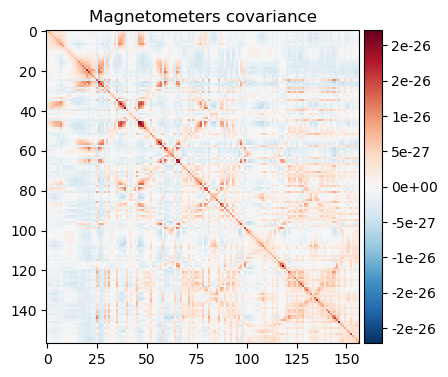

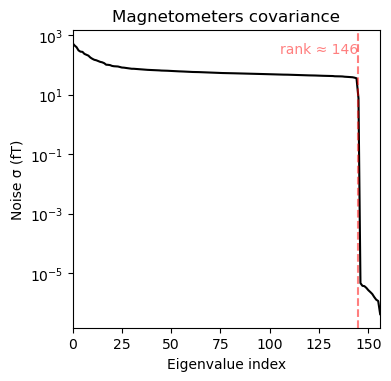

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [91]:
rank = {'mag': 146}
noise_cov_prod = mne.compute_covariance(epochs_aud_prod, tmin=baseline_start, tmax=baseline_end,
                                        method=["shrunk", "empirical"], rank=rank, verbose=True)
mne.viz.plot_cov(noise_cov_prod, aud_prod.info)

In [92]:
raw_fname_prod = directory + sub + '_prod_preproc-raw.fif'
trans = directory + sub + '-trans.fif'

# Compute forward solution
fwd_prod = mne.make_forward_solution(
    raw_fname_prod,
    trans=trans,
    src=src,
    bem=bem,
    meg=True,
    eeg=False,
    mindist=5.0,
    ignore_ref=True
)
lambda2 = 1.0 / snr ** 2

# Calculate inverse operators
inverse_aud_prod = make_inverse_operator(aud_prod.info, fwd_comp, noise_cov_prod, loose=0.2, depth=0.8)

# Calculate STCs using evoked data, inverse operators from above
stc_aud_prod = apply_inverse(aud_prod, inverse_aud_prod, lambda2, method=method, pick_ori="normal")

fname_aud_prod = directory + sub + '_aud_prod'
stc_aud_prod.save(fname_aud_prod, ftype='stc', overwrite=True)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'R3261', ~31.3 MiB>
MRI -> head transform : /Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/MEG_data/R3261/R3261-trans.fif
Measurement data      : R3261_prod_preproc-raw.fif
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999623 0.022839 0.015242      -2.83 mm
    -0.023797 0.997538 0.065970      25.55 mm
    -0.013698 -0.066308 0.997705      39.08 mm
    0.000000 0.000000 0.000000       1.00

Read 157 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
    0.998975 0.013256 0.043289      -3.17 mm
    -0.029395 0.917123 0.397519       3.87 mm
    -0.0

In [50]:
stcs = {
        'Auditory Comprehension':stc_aud_comp,
        'Auditory Production': stc_aud_prod,
}

brains = []

cmaps = ['hot', 'cool']
for (title, stc), cmap in zip(stcs.items(), cmaps):
    brain = stc.plot(
        subjects_dir=subjects_dir,
        hemi='lh',
        colormap=cmap,
        clim=dict(kind="value", lims=[1, 3, 5]),
        smoothing_steps=7,
        title=title
    )
    brain.add_text(0.1, 0.9, title, "title", font_size=14)
    brains.append(brain)  # Save each brain object


# Source Localization -- When you have the rank (testing loose parameter)

In [1]:
def localization_with_rank(sub, comp_rank, prod_rank, loose):
    subjects_dir = '/Applications/freesurfer/8.0.0/subjects' # freesurfer MRI directory
    directory = '/Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/MEG_data/' + sub + '/'

    conductivity = (0.3,) # single layer conductivity
    baseline_start = -300 #in milliseconds
    baseline_end = 0
    baseline = (None,0)
    snr = 3.0
    method = "dSPM"

    # LOAD COMPREHENSION AND PRODUCTION DATA
    # load epochs
    epoch_fname_comp = directory + sub + '_comp-epo.fif'
    epochs_comp = mne.read_epochs(epoch_fname_comp, proj=False)
    epoch_fname_prod = directory + sub + '_prod-epo.fif'
    epochs_prod = mne.read_epochs(epoch_fname_prod, proj=False)


    # Reject bad epochs that have a max peak to peak signal amplitude that exceeds 3 picoteslas
    reject_criteria = dict(mag=3000e-15)
    epochs_prod.drop_bad(reject=reject_criteria)
    epochs_comp.drop_bad(reject=reject_criteria)


    # Equalize epoch counts for each condition
    ident_prod = epochs_prod['production identical'].pick('mag')
    unrel_prod = epochs_prod['production unrelated'].pick('mag')
    ident_comp = epochs_comp['comprehension identical'].pick('mag')
    unrel_comp = epochs_comp['comprehension unrelated'].pick('mag')
    mne.epochs.equalize_epoch_counts([ident_prod, ident_comp, unrel_prod, unrel_comp], method="random")

    # Create evoked objects low pass filtered at 40 Hz
    ident_prod = ident_prod.average().filter(l_freq=None, h_freq=20)
    unrel_prod = unrel_prod.average().filter(l_freq=None, h_freq=20)
    ident_comp = ident_comp.average().filter(l_freq=None, h_freq=20)
    unrel_comp = unrel_comp.average().filter(l_freq=None, h_freq=20)

    # Make anatomical model -- does not use head position information
    subject = sub
    model = mne.make_bem_model(subject=subject, ico=4, conductivity=conductivity, subjects_dir=subjects_dir)
    bem = mne.make_bem_solution(model)
    src = mne.setup_source_space(subject, spacing="oct6", add_dist="patch", subjects_dir=subjects_dir)

    rank = {'mag': comp_rank}
    noise_cov_comp = mne.compute_covariance(epochs_comp, tmin=baseline_start, tmax=baseline_end,
                                        method=["shrunk", "empirical"], rank=rank, verbose=True)
    # mne.viz.plot_cov(noise_cov_comp, epochs_comp.info)

    raw_fname_comp = directory + sub + '_comp_preproc-raw.fif'
    trans = directory + sub + '-trans.fif'

    # Compute forward solution
    fwd_comp = mne.make_forward_solution(
        raw_fname_comp,
        trans=trans,
        src=src,
        bem=bem,
        meg=True,
        eeg=False,
        mindist=5.0,
        ignore_ref=True
    )
    lambda2 = 1.0 / snr ** 2

    # Calculate inverse operators
    inverse_ident_comp = make_inverse_operator(ident_comp.info, fwd_comp, noise_cov_comp, loose=loose, depth=0.8)
    inverse_unrel_comp = make_inverse_operator(unrel_comp.info, fwd_comp, noise_cov_comp, loose=loose, depth=0.8)

    # Calculate STCs using evoked data, inverse operators from above
    stc_ident_comp = apply_inverse(ident_comp, inverse_ident_comp, lambda2, method=method, pick_ori="normal")
    stc_unrel_comp = apply_inverse(unrel_comp, inverse_unrel_comp, lambda2, method=method, pick_ori="normal")

    fname_ident_comp = directory + sub + '_ident_comp_filt'
    stc_ident_comp.save(fname_ident_comp, ftype='stc', overwrite=False)
    fname_unrel_comp = directory + sub + '_unrel_comp_filt'
    stc_unrel_comp.save(fname_unrel_comp, ftype='stc', overwrite=False)



    rank = {'mag': prod_rank}
    noise_cov_prod = mne.compute_covariance(epochs_prod, tmin=baseline_start, tmax=baseline_end, method=["shrunk", "empirical"], rank=rank, verbose=True)
    # mne.viz.plot_cov(noise_cov_prod, epochs_prod.info)

    raw_fname_prod = directory + sub + '_prod_preproc-raw.fif'
    trans = directory + sub + '-trans.fif'

    # Compute forward solution
    fwd_prod = mne.make_forward_solution(
        raw_fname_prod,
        trans=trans,
        src=src,
        bem=bem,
        meg=True,
        eeg=False,
        mindist=5.0,
        ignore_ref=True
    )
    lambda2 = 1.0 / snr ** 2

    # Calculate inverse operators
    inverse_ident_prod = make_inverse_operator(ident_prod.info, fwd_prod, noise_cov_prod, loose=loose, depth=0.8)
    inverse_unrel_prod = make_inverse_operator(unrel_prod.info, fwd_prod, noise_cov_prod, loose=loose, depth=0.8)

    # Calculate STCs using evoked data, inverse operators from above
    stc_ident_prod = apply_inverse(ident_prod, inverse_ident_prod, lambda2, method=method, pick_ori="normal")
    stc_unrel_prod = apply_inverse(unrel_prod, inverse_unrel_prod, lambda2, method=method, pick_ori="normal")

    fname_ident_comp = directory + sub + '_ident_prod_filt'
    stc_ident_prod.save(fname_ident_comp, ftype='stc', overwrite=False)
    fname_unrel_comp = directory + sub + '_unrel_prod_filt'
    stc_unrel_prod.save(fname_unrel_comp, ftype='stc', overwrite=False)

In [3]:
subs = ['R3250', 'R3254', 'R3261', 'R3264', 'R3270','R3271','R3272','R3273','R3275','R3277','R3279','R3285','R3286','R3289','R3290']
comp_ranks = [153,147,147,147,144,149,148,147,149,145,148,147,148,148,147]
prod_ranks =  [147,147,147,147,147,149,148,148,149,145,146,147,147,149,148]

for i in range(len(subs)):
    localization_with_rank(subs[i], comp_ranks[i], prod_ranks[i], 0.2)

Reading /Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/MEG_data/R3250/R3250_comp-epo.fif ...
    Read a total of 2 projection items:
        axial-Raw-0.000-120.000-PCA-01 (1 x 155) active
        axial-Raw-0.000-120.000-PCA-02 (1 x 155) active
    Found the data of interest:
        t =    -300.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
100 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
Reading /Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/MEG_data/R3250/R3250_prod-epo.fif ...
    Read a total of 2 projection items:
        axial-Raw-0.000-120.000-PCA-01 (1 x 155) active
        axial-Raw-0.000-120.000-PCA-02 (1 x 155) active
    Found the data of interest:
        t =    -300.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
97 matching events found
No baseline correction applied
Created an SSP operator (s